In [19]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from feature_engine.discretisation import EqualFrequencyDiscretiser
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTEN
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

## Dataset description
---

| Feature                  | Explanation                                               | Measurement      | Range               |
|--------------------------|-----------------------------------------------------------|------------------|---------------------|
| Age                      | Age of the patient                                        | Years            | [40,..., 95]        |
| Anaemia                  | Decrease of red blood cells or hemoglobin                 | Boolean          | 0, 1                |
| Creatinine phosphokinase | Level of the CPK enzyme in the blood                      | mcg/L            | [23,..., 7861]      |
| Diabetes                 | If the patient has diabetes                               | Boolean          | 0, 1                |
| Ejection fraction        | Percentage of blood leaving the heart at each contraction | Percentage       | [14,..., 80]        |
| High blood pressure      | If a patient has hypertension                             | Boolean          | 0, 1                |
| Platelets                | Platelets in the blood                                    | kiloplatelets/mL | [25.01,..., 850.00] |
| Serum creatinine         | Level of creatinine in the blood                          | mg/dL            | [0.50,..., 9.40]    |
| Serum sodium             | Level of sodium in the blood                              | mEq/L            | [114,..., 148]      |
| Sex                      | Woman or man                                              | Binary           | 0, 1                |
| Smoking                  | If the patient smokes                                     | Boolean          | 0, 1                |
| Time                     | Follow-up period                                          | Days             | [4,...,285]         |
| Death event (target)     | If the patient died during the follow-up period           | Boolean          | 0, 1                |

## Exploratory Data Analysis
---

### Loading the dataset

In [4]:
DATA_PATH = "Dados/heart_failure_clinical_records_dataset.csv"
heart_df = pd.read_csv(DATA_PATH)
heart_df.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

### Looking the data shape
* The dataset has 299 instances and 13 features/variables

In [3]:
heart_df.shape

(299, 13)

### Checking features data types
* The features are already numerical, so isn't necessary to apply object to numerical conversion

In [4]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


### Statistical description of the dataset

In [22]:
heart_df.describe()

age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.000000             0.000000  212500.000000   
50%            38.000000             0.000000  262000.000000   
75%            45.000000             1.000000  303500.000000   
max            80.000000             1.000000  850000.000000   

       serum_creatinine  serum_sodium         sex    smoking        time  \
count         299.00000    299.000000  299.000000  299.00000  299.000000   
mean            1.39388    136.625418    0.648829    0.32107  130.260870   
std             1.03451      4.412477    0.478136    0.46767   77.614208   
min             0.50000    113.000000    0.000000    0.00000    4.000000   
25%             0.90000    134.000000    0.000000    0.00000   73.000000   
50%             1.10000    137.000000    1.000000    0.00000  115.000000   
75%             1.40000    140.000000    1.000000    1.00000  203.000000   
max             9.40000    148.000000    1.000000    1.00000  285.000000   

       DEATH_EVENT  
count    299.00000  
mean       0.32107  
std        0.46767  
min        0.00000  
25%        0.00000  
50%        0.00000  
75%        1.00000  
max        1.00000

### Checking for missing values
* The dataset don't have missing values

<AxesSubplot:>

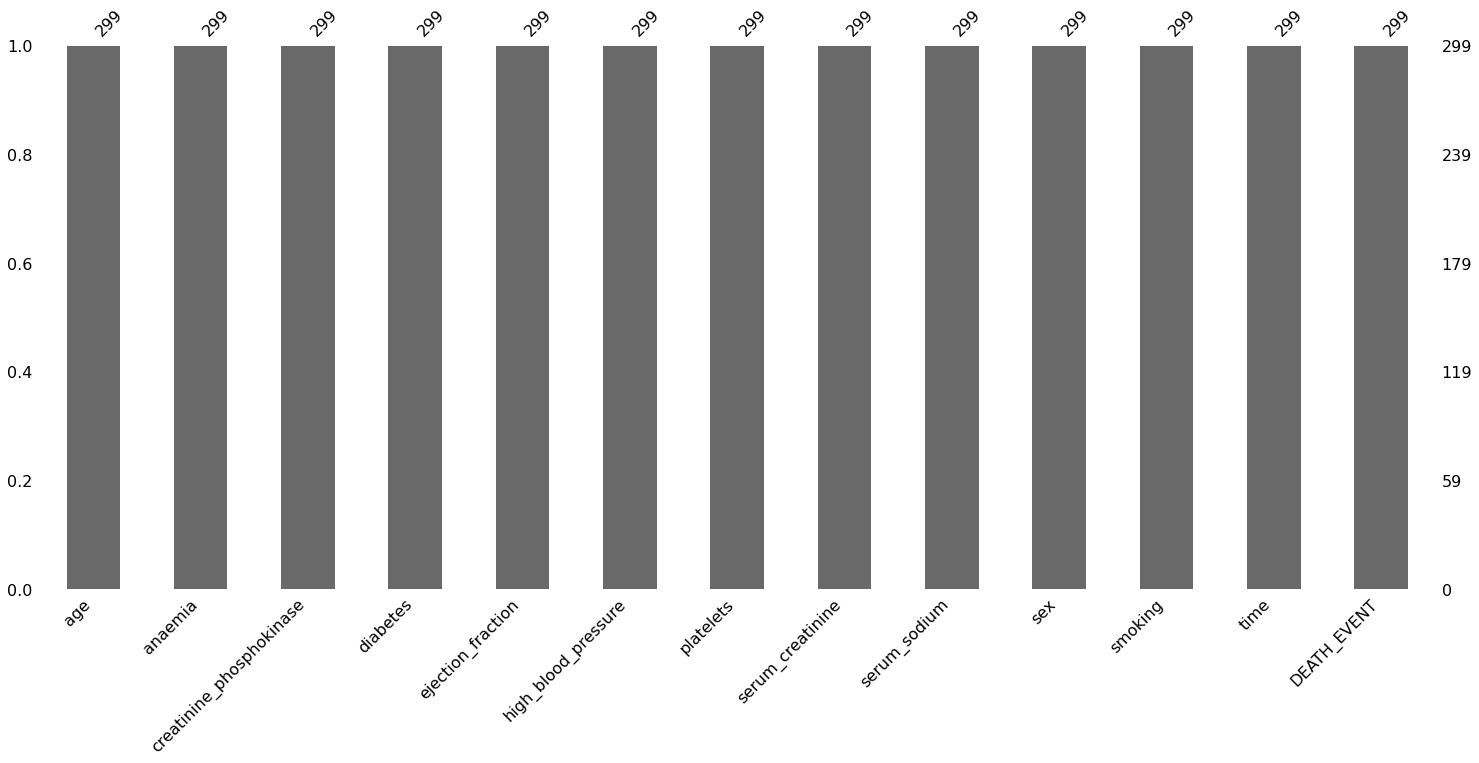

In [21]:
msno.bar(heart_df)

### Looking at the target variable (DEATH_EVENT)
* The target output is imbalanced

In [5]:
heart_df.DEATH_EVENT.value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

#### Count plot of the target variable

Don't Died: 67.89% of cases (203)
Died: 32.11% of cases (96)
Proportion of the output: 2.11


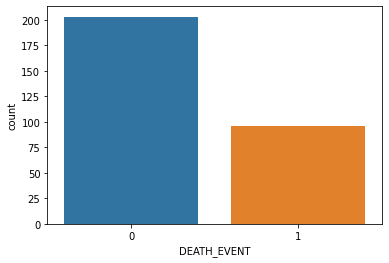

In [45]:
sns.countplot(data=heart_df, x='DEATH_EVENT')
valores = heart_df.DEATH_EVENT.value_counts().values
print('Don\'t Died: {:.2f}% of cases ({:.0f})'.format(valores[0]/(valores[1]+valores[0])*100, valores[0]))
print('Died: {:.2f}% of cases ({:.0f})'.format(valores[1]/(valores[1]+valores[0])*100, valores[1]))
print('Proportion of the output: {:.2f}'.format(valores[0]/valores[1]))

### Correlation between variables

<AxesSubplot:>

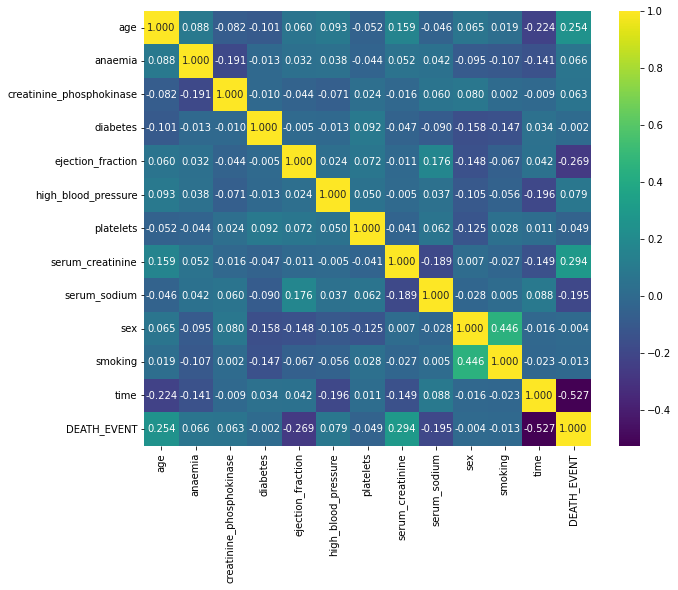

In [24]:
plt.figure(figsize=(10,8))
mask = np.triu(np.ones(heart_df.corr().shape[0]))
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if i==j:
            mask[i,j] = 0
        else:
            continue
sns.heatmap(heart_df.corr(), annot=True, cmap='viridis', fmt='.3f')#, mask=mask)

### Features correlations for pearson's score higher than 0.1 (absolute)

<AxesSubplot:>

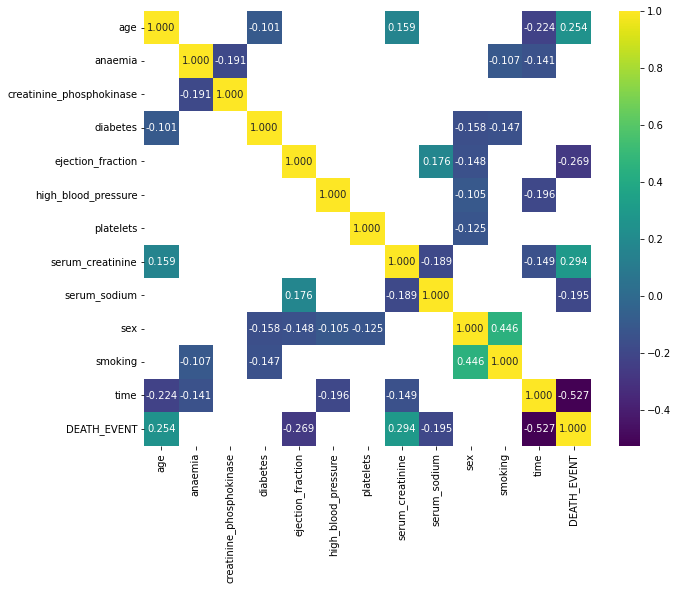

In [42]:
plt.figure(figsize=(10,8))
sns.heatmap(heart_df.corr()[np.abs(heart_df.corr()) > 0.1] , annot=True, cmap='viridis', fmt='.3f')#, mask=mask)

### Dropping features with less than 1% of correlation with our target

In [18]:
bigger_than_1perc = np.abs(heart_df.corr()['DEATH_EVENT']) > 0.01
new_features_list = heart_df.corr()[bigger_than_1perc]['DEATH_EVENT'].index.to_list()
heart_df_new = heart_df[new_features_list]
heart_df_new.head()

age  anaemia  creatinine_phosphokinase  ejection_fraction  \
0  75.0        0                       582                 20   
1  55.0        0                      7861                 38   
2  65.0        0                       146                 20   
3  50.0        1                       111                 20   
4  65.0        1                       160                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  smoking  \
0                    1  265000.00               1.9           130        0   
1                    0  263358.03               1.1           136        0   
2                    0  162000.00               1.3           129        1   
3                    0  210000.00               1.9           137        0   
4                    0  327000.00               2.7           116        0   

   time  DEATH_EVENT  
0     4            1  
1     6            1  
2     7            1  
3     7            1  
4     8            1

### Checking the mean values for the features relative to the DEATH_EVENT variable
* There are slightly differences between the two outputs for DEATH_EVENT

In [22]:
heart_df_new.groupby(['DEATH_EVENT']).mean()

age   anaemia  creatinine_phosphokinase  ejection_fraction  \
DEATH_EVENT                                                                     
0            58.761906  0.408867                540.054187           40.26601   
1            65.215281  0.479167                670.197917           33.46875   

             high_blood_pressure      platelets  serum_creatinine  \
DEATH_EVENT                                                         
0                       0.325123  266657.489901          1.184877   
1                       0.406250  256381.044792          1.835833   

             serum_sodium   smoking        time  
DEATH_EVENT                                      
0              137.216749  0.325123  158.339901  
1              135.375000  0.312500   70.885417

### Looking at variance for continuous features
* The values are in a very different scale, for some Machine Learning models the feature scaling will be necessary

In [26]:
# Observando a variância das features contínuas
a = heart_df_new[['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']].var()
make_float = lambda x: "{:.2f}".format(x)
a.apply(make_float)

age                                141.49
creatinine_phosphokinase        941458.57
ejection_fraction                  140.06
platelets                   9565668749.45
serum_creatinine                     1.07
serum_sodium                        19.47
time                              6023.97
dtype: object

### Looking at features Histograms

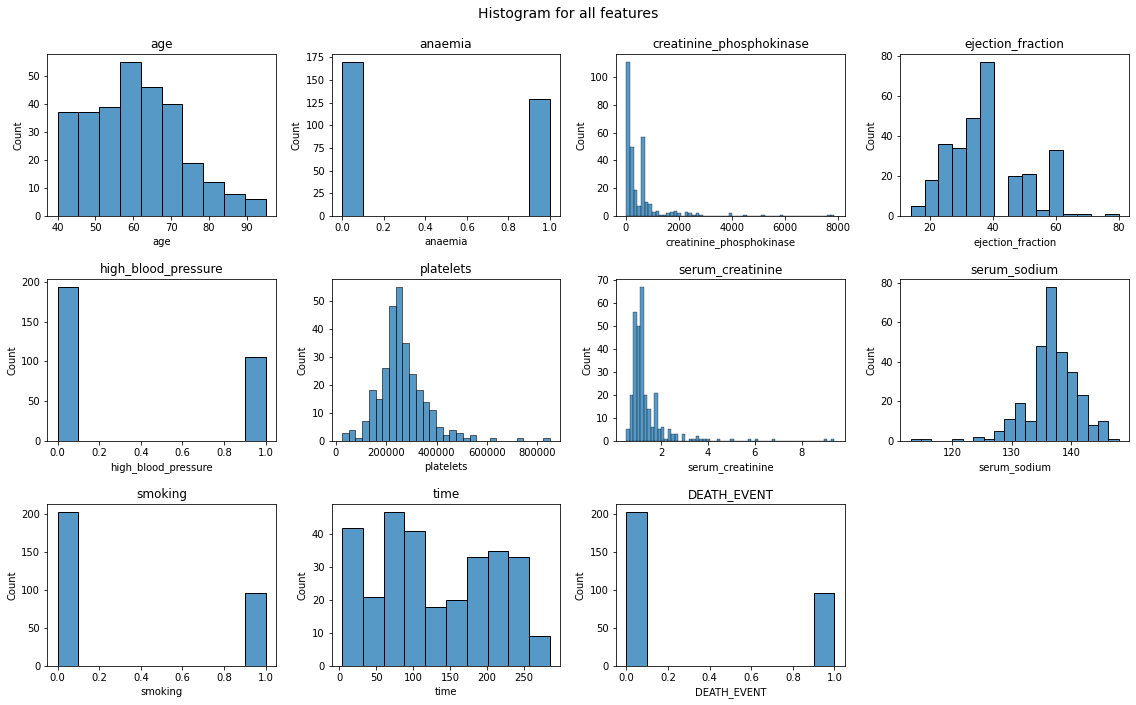

In [74]:
fig = plt.figure(figsize=(16,10))
fig.suptitle('Histogram for all features', fontsize=14, ha='center')
count = 1
for column in heart_df_new.columns.to_list():
    ax = fig.add_subplot(3,4,count)
    ax.set_title(f'{column}')
    sns.histplot(data=heart_df_new, x=column, ax=ax)
    count+=1
fig.tight_layout(pad=1.5)
fig.subplots_adjust(top=.915)
plt.show()

### Looking at Boxplots for continuous features
* There are some outliers that need to be removed to not mess with our classification model

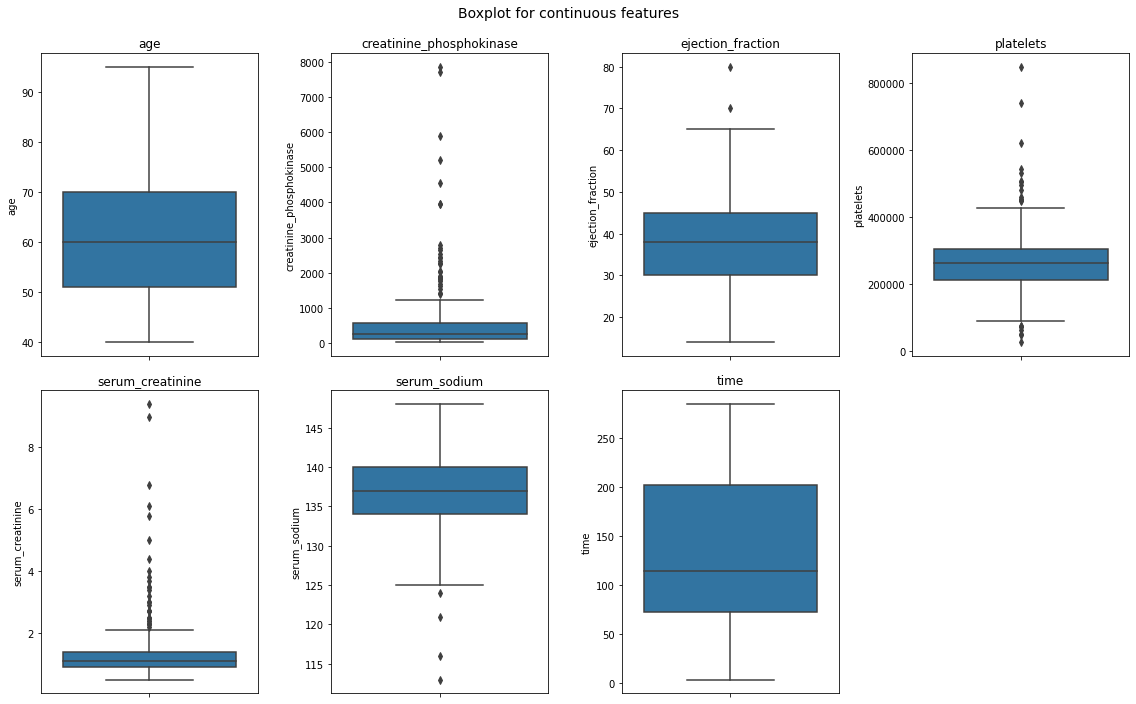

In [92]:
fig = plt.figure(figsize=(16,10))
fig.suptitle('Boxplot for continuous features', fontsize=14, ha='center')
count = 1
columns_continuous = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
for column in columns_continuous:
    #plt.subplot(7,2,count)
    ax = fig.add_subplot(2,4,count)
    ax.set_title(f'{column}')
    sns.boxplot(data=heart_df_new, y=column, ax=ax)
    count+=1
fig.tight_layout(pad=1.5)
fig.subplots_adjust(top=.915)
plt.show()

## Removing noise from data
   ---

### Removing outliers

Using Z-score outlier metric ( mean +/- 3 * standard deviation )

In [28]:
# Using score Z outlier metric ( mean +/- 3 * standard deviation )
def remove_outliers(df, continuous_features=None, outliers_index=False):

    if continuous_features:
        features_list = continuous_features
    else:
        features_list = df.columns.to_list()
    boolean_mask = np.array([])
    print(df.shape)

    for feature in features_list:
        mean = df[feature].mean()
        std = df[feature].std()
        upper = mean + 3*std
        lower = mean - 3*std
        mask_f = (df[feature] < upper) & (df[feature] > lower)
        if feature == features_list[0]:
            boolean_mask = mask_f
        else:
            boolean_mask = np.vstack((boolean_mask,mask_f.values))

    no_outlier_idx = np.all(boolean_mask.T, axis=1)
    df_no_outlier = df[no_outlier_idx]
    print(df_no_outlier.shape)
    if outliers_index:
        return df_no_outlier, ~no_outlier_idx
    else:
        return df_no_outlier



In [29]:
heart_df_no_outlier, outliers_ind = remove_outliers(heart_df_new, columns_continuous, outliers_index=True)

(299, 11)
(280, 11)


In [30]:
outliers = heart_df[outliers_ind]
outliers

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
1    55.0        0                      7861         0                 38   
4    65.0        1                       160         1                 20   
9    80.0        1                       123         0                 35   
19   48.0        1                       582         1                 55   
28   58.0        1                        60         0                 38   
52   60.0        0                      3964         1                 62   
60   45.0        0                      7702         1                 25   
64   45.0        0                       582         0                 80   
72   85.0        0                      5882         0                 35   
103  42.0        0                      5209         0                 30   
105  72.0        1                       328         0                 30   
109  45.0        0                       292         1                 35   
131  60.0        1                      1082         1                 45   
134  81.0        0                      4540         0                 35   
171  52.0        0                      3966         0                 40   
199  60.0        0                      1211         1                 35   
217  54.0        1                       427         0                 70   
228  65.0        0                        56         0                 25   
296  45.0        0                      2060         1                 60   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
1                      0  263358.03              1.10           136    1   
4                      0  327000.00              2.70           116    0   
9                      1  388000.00              9.40           133    1   
19                     0   87000.00              1.90           121    0   
28                     0  153000.00              5.80           134    1   
52                     0  263358.03              6.80           146    0   
60                     1  390000.00              1.00           139    1   
64                     0  263358.03              1.18           137    0   
72                     0  243000.00              1.00           132    1   
103                    0  226000.00              1.00           140    1   
105                    1  621000.00              1.70           138    0   
109                    0  850000.00              1.30           142    1   
131                    0  250000.00              6.10           131    1   
134                    0  231000.00              1.18           137    1   
171                    0  325000.00              0.90           140    1   
199                    0  263358.03              1.80           113    1   
217                    1  151000.00              9.00           137    0   
228                    0  237000.00              5.00           130    0   
296                    0  742000.00              0.80           138    0   

     smoking  time  DEATH_EVENT  
1          0     6            1  
4          0     8            1  
9          1    10            1  
19         0    15            1  
28         0    26            1  
52         0    43            1  
60         0    60            1  
64         0    63            0  
72         1    72            1  
103        1    87            0  
105        1    88            1  
109        1    88            0  
131        0   107            0  
134        1   107            0  
171        1   146            0  
199        1   186            0  
217        0   196            1  
228        0   207            0  
296        0   278            0

In [87]:
outliers.DEATH_EVENT.value_counts()

1    10
0     9
Name: DEATH_EVENT, dtype: int64

Não morreram: 69.29% dos casos
Morreram: 30.71% dos casos
Proporção: 2.26


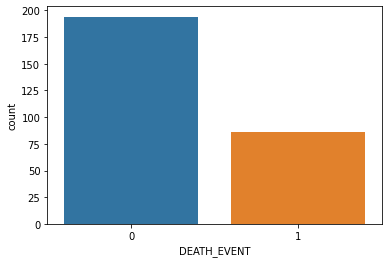

In [31]:
sns.countplot(data=heart_df_no_outlier, x='DEATH_EVENT')
valores = heart_df_no_outlier.DEATH_EVENT.value_counts().values
print('Não morreram: {:.2f}% dos casos'.format(valores[0]/(valores[1]+valores[0])*100))
print('Morreram: {:.2f}% dos casos'.format(valores[1]/(valores[1]+valores[0])*100))
print('Proporção: {:.2f}'.format(valores[0]/valores[1]))

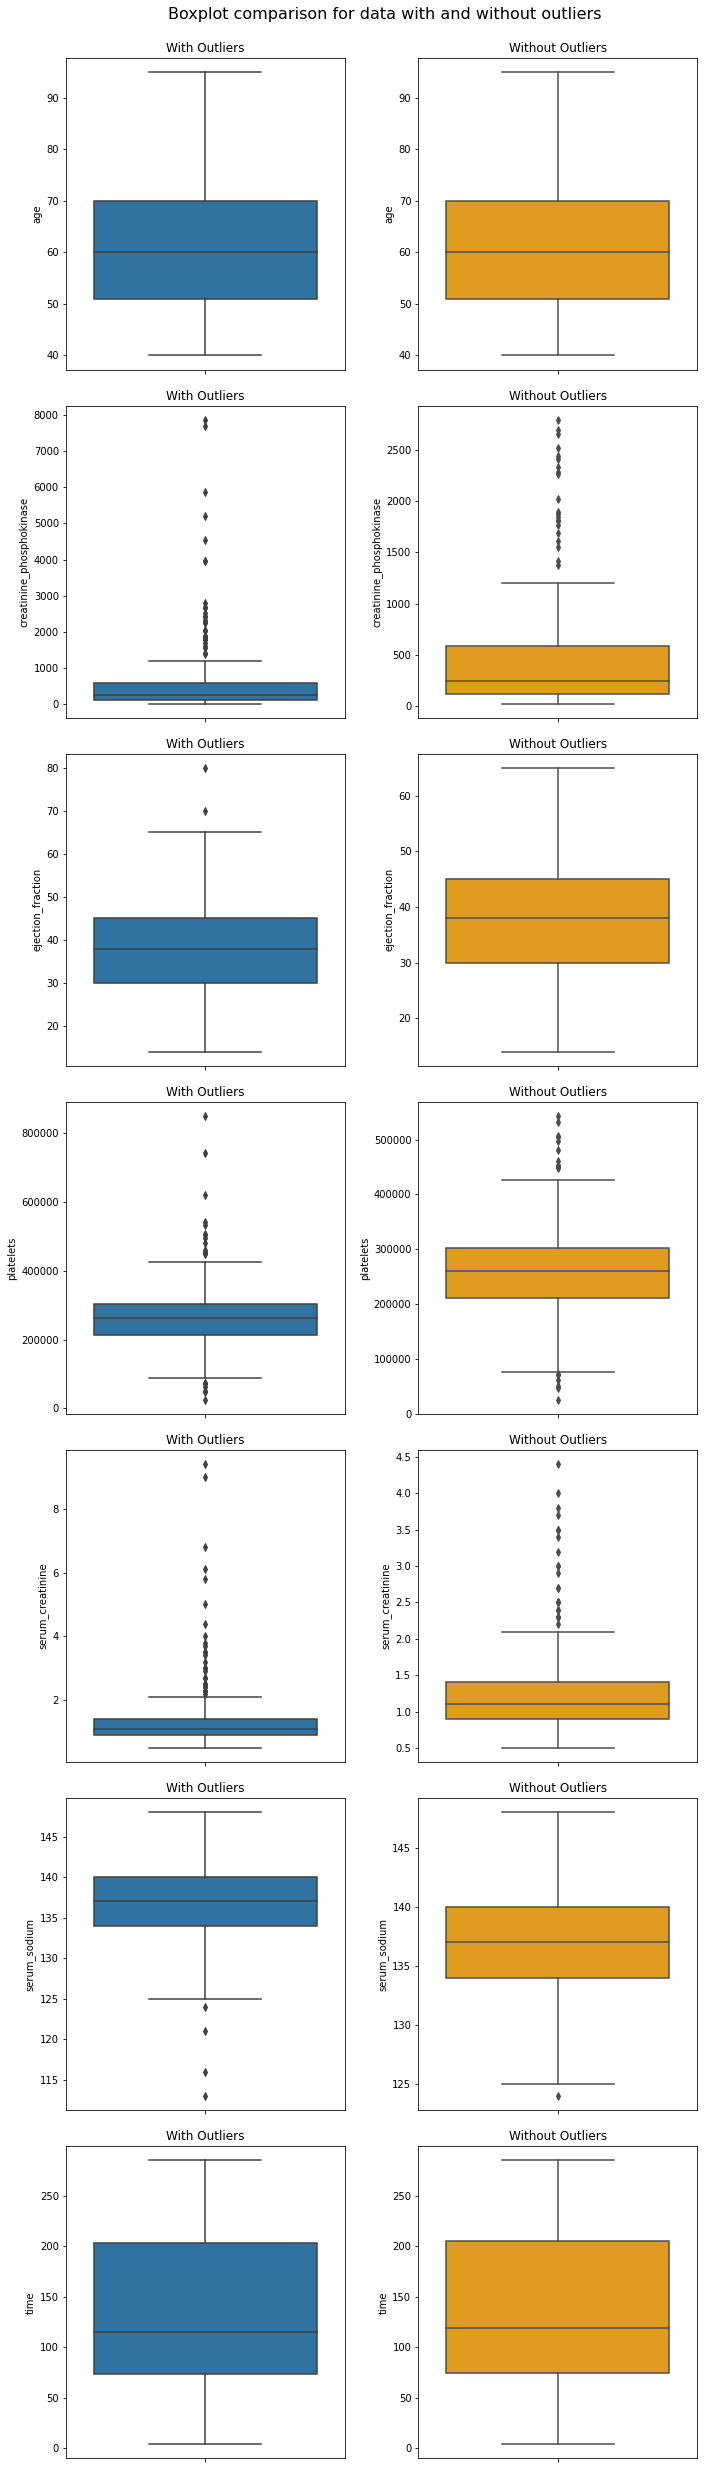

In [77]:
fig = plt.figure(figsize=(10,35))
fig.suptitle('Boxplot comparison for data with and without outliers', fontsize=16, x = 0.545)#, dpi=300)
count = 1
for column in columns_continuous:
    #plt.subplot(7,2,count)
    ax = fig.add_subplot(7,2,count)
    ax.set_title('With Outliers')
    sns.boxplot(data=heart_df, y=column, ax=ax)
    count+=1
    #plt.subplot(7,2,count)
    ax = fig.add_subplot(7,2,count)
    ax.set_title('Without Outliers')
    sns.boxplot(data=heart_df_no_outlier, y=column, color='orange', ax=ax)
    count+=1
fig.tight_layout(pad = 1.5)
fig.subplots_adjust(top=.96)
plt.show()

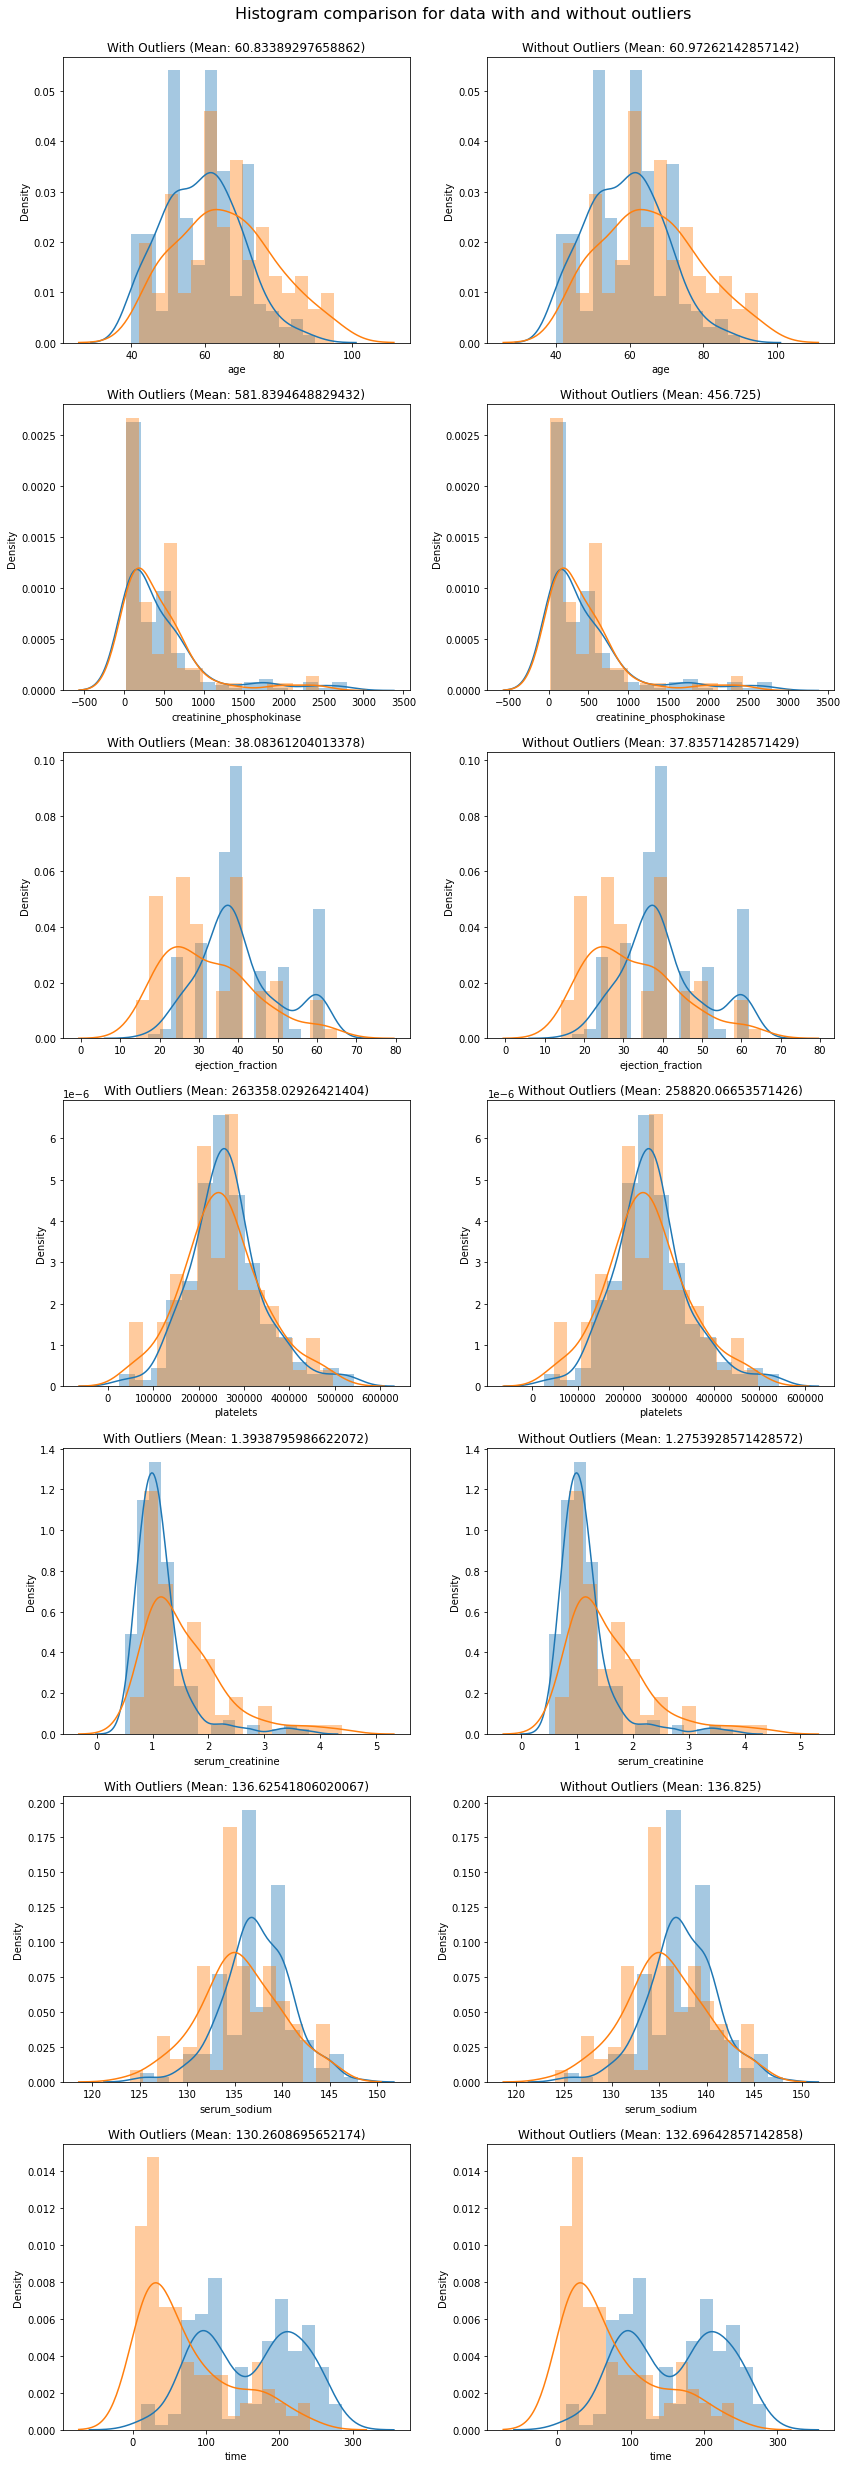

In [82]:
fig = plt.figure(figsize=(12,35))
fig.suptitle('Histogram comparison for data with and without outliers', fontsize=16, x = 0.545)#, dpi=300)
count = 1

for column in columns_continuous:
    ax = fig.add_subplot(7,2,count)
    ax.set_title(f'With Outliers (Mean: {heart_df_new[column].mean()})')
    #sns.histplot(data=heart_df_new, x=column, hue='DEATH_EVENT', kde=True, ax = ax)
    sns.distplot(a=heart_df_no_outlier[heart_df_no_outlier['DEATH_EVENT'] == 0][column], bins=15, ax=ax)
    sns.distplot(a=heart_df_no_outlier[heart_df_no_outlier['DEATH_EVENT'] == 1][column], bins=15, ax=ax)
    count+=1

    ax = fig.add_subplot(7,2,count)
    ax.set_title(f'Without Outliers (Mean: {heart_df_no_outlier[column].mean()})')
    #sns.histplot(data=heart_df_no_outlier, x=column, hue='DEATH_EVENT', color='orange', kde=True, ax = ax)
    sns.distplot(a=heart_df_no_outlier[heart_df_no_outlier['DEATH_EVENT'] == 0][column], bins=15, ax=ax)
    sns.distplot(a=heart_df_no_outlier[heart_df_no_outlier['DEATH_EVENT'] == 1][column], bins=15,ax=ax)
    count+=1

fig.tight_layout(pad = 1.5)
fig.subplots_adjust(top=.96)
plt.show()

## Training and Validation
---

### Choosing our features and setting our target

In [84]:
# sem tempo, com tempo, sem tempo scale, com tempo scale, sem tempo discreto, com tempo discreto
X = heart_df_no_outlier.drop(['DEATH_EVENT','time'], axis=1)
X_t = heart_df_no_outlier.drop('DEATH_EVENT', axis=1)
y = heart_df_no_outlier['DEATH_EVENT']

### Splitting our data into training and test

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=5, stratify=y)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t,y,test_size=.3,random_state=5,stratify=y)

### Scaling and Discretizing the data

In [120]:
columns_continuous_not = columns_continuous.copy()
columns_continuous_not.pop()

discretizer = EqualFrequencyDiscretiser(variables=columns_continuous_not, q=8)
discretizer_t = EqualFrequencyDiscretiser(variables=columns_continuous, q=8)

#scaler = StandardScaler()
scaler = MinMaxScaler()

#Discrete without Time
discrete = discretizer.fit_transform(X_train)
X_train_d = pd.DataFrame()
for column in X_train.columns.to_list():
    if column in discrete.columns.to_list():
        X_train_d[column] = discrete[column]
    else:
        X_train_d[column] = X_train[column]
discrete_test = discretizer.transform(X_test)
X_test_d = pd.DataFrame()
for column in X_test.columns.to_list():
    if column in discrete_test.columns.to_list():
        X_test_d[column] = discrete_test[column]
    else:
        X_test_d[column] = X_test[column]

# Discrete with Time
discrete_t = discretizer_t.fit_transform(X_train_t)
X_train_dt = pd.DataFrame()
for column in X_train_t.columns.to_list():
    if column in discrete_t.columns.to_list():
        X_train_dt[column] = discrete_t[column]
    else:
        X_train_dt[column] = X_train_t[column]
discrete_test_t = discretizer_t.transform(X_test_t)
X_test_dt = pd.DataFrame()
for column in X_test_t.columns.to_list():
    if column in discrete_test_t.columns.to_list():
        X_test_dt[column] = discrete_test_t[column]
    else:
        X_test_dt[column] = X_test_t[column]
# Scaled without Time
X_train_s = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns.to_list())
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns.to_list())

#Scaled with Time
X_train_st = pd.DataFrame(scaler.fit_transform(X_train_t), columns=X_train_t.columns.to_list())
X_test_st = pd.DataFrame(scaler.transform(X_test_t), columns=X_test_t.columns.to_list())

### Applying SMOTE to handle with imbalanced data

In [126]:
smote = SMOTENC(categorical_features= [1, 4, 8],random_state=5)
smotec = SMOTEN(random_state=5)

X_train_res, y_train_res = smote.fit_resample(X_train,y_train)
X_train_res_t, y_train_res_t = smote.fit_resample(X_train_t,y_train_t)

X_train_d_res, y_train_d = smotec.fit_resample(X_train_d,y_train)
X_train_dt_res, y_train_dt = smotec.fit_resample(X_train_dt,y_train_t)

X_train_s_res, y_train_s = smote.fit_resample(X_train_s,y_train)
X_train_st_res, y_train_st = smote.fit_resample(X_train_st,y_train_t)

### Choosing the best Tree based model

#### Using Decision Tree to make the initial classification
* The Classification Report show some important metrics to evaluate the tree classifier
* The plot show how the tree split to fit the training data
* The scores can be improved if we use Random Forests instead of one Decision Tree

              precision    recall  f1-score   support

           0       0.82      0.79      0.81        58
           1       0.57      0.62      0.59        26

    accuracy                           0.74        84
   macro avg       0.70      0.70      0.70        84
weighted avg       0.74      0.74      0.74        84



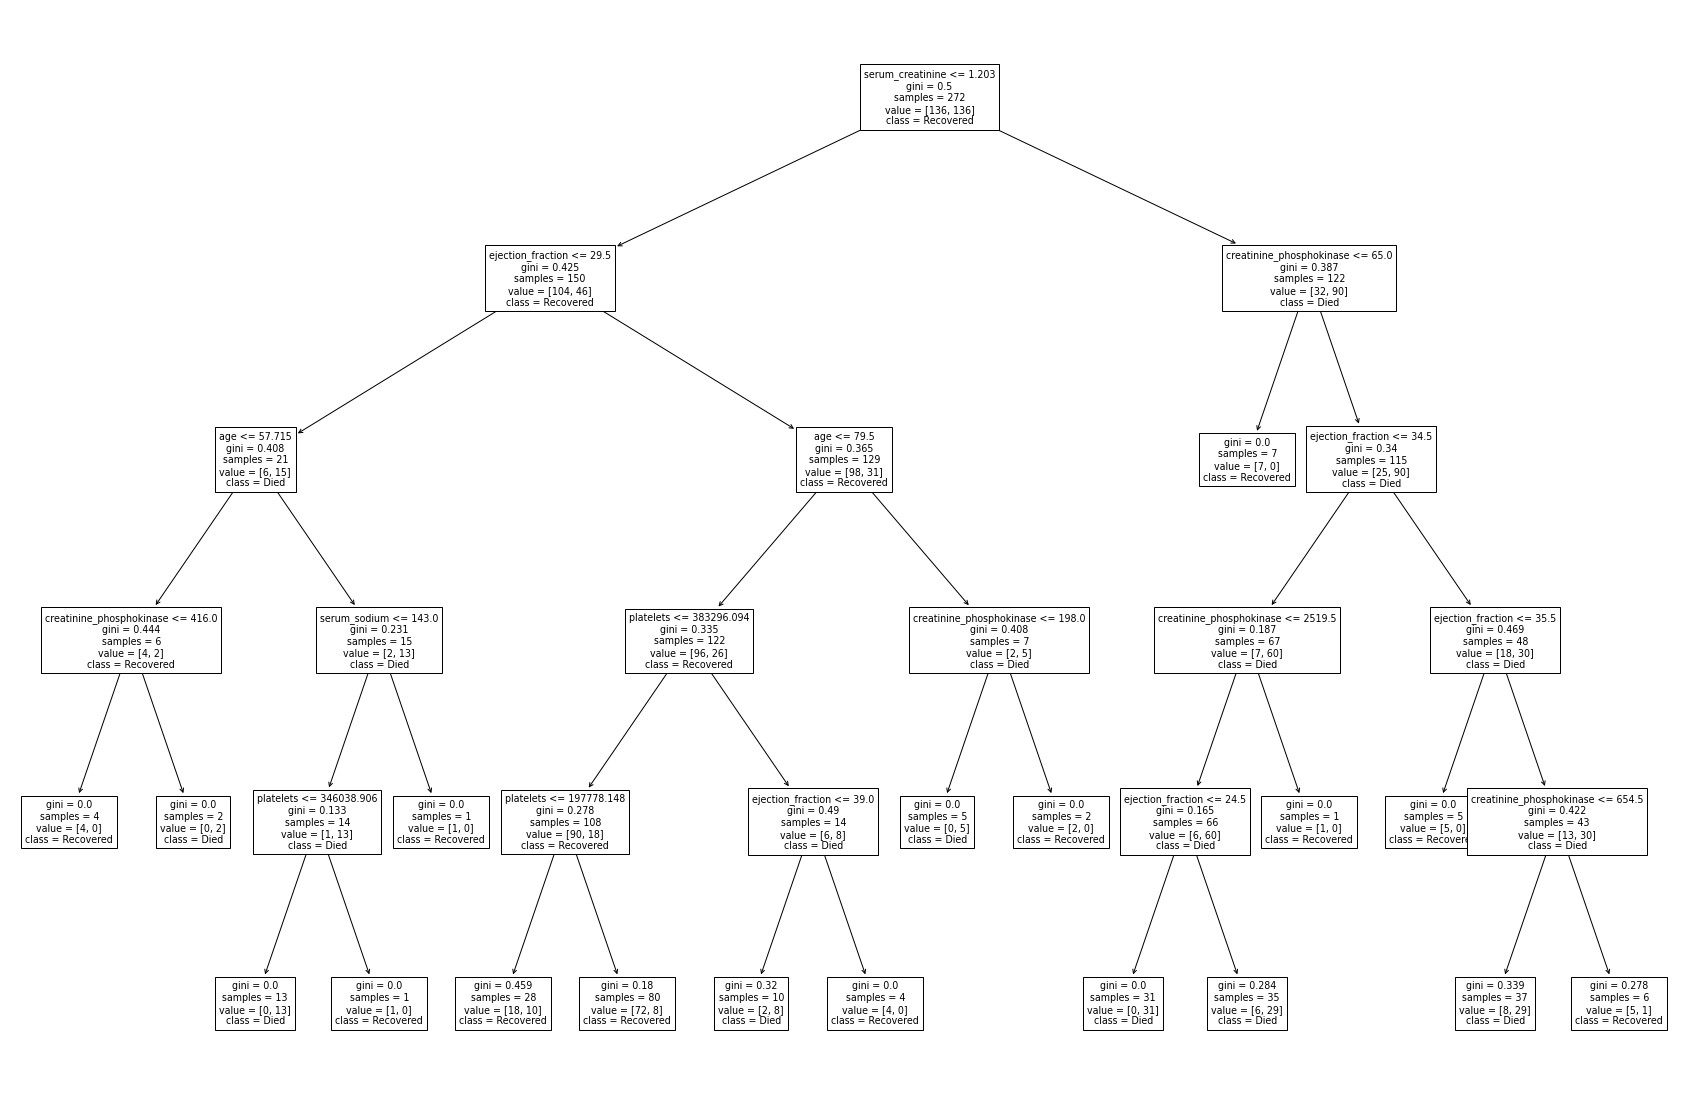

In [198]:
clf_tree = DecisionTreeClassifier(random_state=5, max_depth=5)
clf_tree.fit(X_train_res,y_train_res)
print(classification_report(y_test,clf_tree.predict(X_test)))
plt.figure(figsize=(30,20))
plot_tree(clf_tree, feature_names=X_train_res.columns.to_list(), class_names=['Recovered', 'Died'], fontsize=9.5)
plt.savefig('tree.png')
plt.show()

##### Confusion Matrix for decision tree

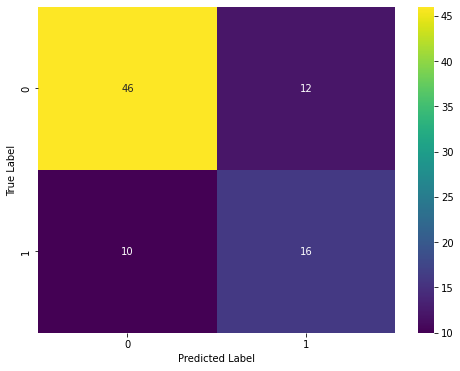

In [218]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, clf_tree.predict(X_test)),cmap='viridis', annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##### ROC curve for Decision Tree

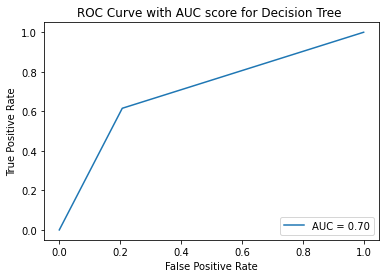

In [225]:
fpr, tpr, thresholds = roc_curve(y_test,clf_tree.predict(X_test))
roc_auc = auc(fpr,tpr)
roc = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc)
roc.plot()
plt.title('ROC Curve with AUC score for Decision Tree ')
plt.show()

##### Feature importances for the decision tree classifier

In [200]:
features = X_train_res.columns.to_list()
features_val = clf_tree.feature_importances_

features_importances = {}

for key,value in zip(features,features_val):
    features_importances[key] = value

sort_features = dict(sorted(features_importances.items(), key=lambda item: item[1], reverse=True))

print('Feature Importances for Decision Tree:\n')
for key,value in zip(sort_features.keys(), sort_features.values()):
    print(f'{key}:',value)

Feature Importances for Decision Tree:

serum_creatinine: 0.30715518808747294
ejection_fraction: 0.2603599810712565
creatinine_phosphokinase: 0.23548816839781692
platelets: 0.10640856066692554
age: 0.07081333113287568
serum_sodium: 0.019774770643652496
anaemia: 0.0
high_blood_pressure: 0.0
smoking: 0.0


#### Using Random Forest to improve the score
* As expected, the scores were better

In [227]:
clf_rf = RandomForestClassifier(random_state=5)#, max_depth=8, n_estimators=100)
clf_rf.fit(X_train_res,y_train_res)
print(classification_report(y_test,clf_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84        58
           1       0.64      0.62      0.63        26

    accuracy                           0.77        84
   macro avg       0.74      0.73      0.73        84
weighted avg       0.77      0.77      0.77        84



##### Confusion matrix for Random Forest

Text(51.0, 0.5, 'True Label')

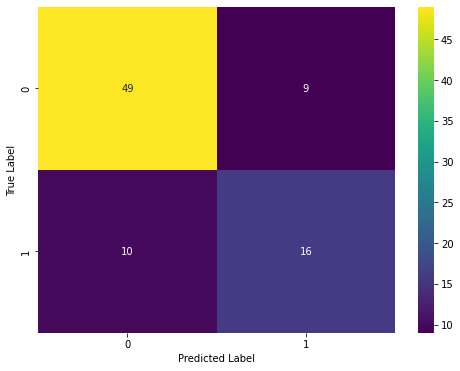

In [212]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, clf_rf.predict(X_test)),cmap='viridis', annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

##### ROC curve for Random Forest

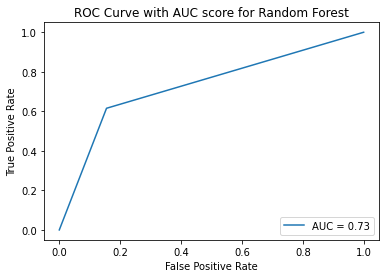

In [230]:
fpr, tpr, thresholds = roc_curve(y_test,clf_rf.predict(X_test))
roc_auc = auc(fpr,tpr)
roc = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc)
roc.plot()
plt.title('ROC Curve with AUC score for Random Forest')
plt.show()

##### Features Importances for Random Forest

In [213]:
features = X_train_res.columns.to_list()
features_val = clf_rf.feature_importances_

features_importances = {}

for key,value in zip(features,features_val):
    features_importances[key] = value

sort_features = dict(sorted(features_importances.items(), key=lambda item: item[1], reverse=True))

for key,value in zip(sort_features.keys(), sort_features.values()):
    print(f'{key}:',value)

serum_creatinine: 0.24959796944873913
ejection_fraction: 0.18246742539309144
platelets: 0.13973738494982005
age: 0.13552502445670014
creatinine_phosphokinase: 0.13455543718121094
serum_sodium: 0.09880643713607709
smoking: 0.026328040118561463
anaemia: 0.019230006774712143
high_blood_pressure: 0.013752274541087562


### Trying to improve the scores using the other train/test sets

In [214]:
clf_rf.fit(X_train_res_t,y_train_res_t)
y_pred = clf_rf.predict(X_test_t)
print(classification_report(y_test_t,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        58
           1       0.68      0.73      0.70        26

    accuracy                           0.81        84
   macro avg       0.78      0.79      0.78        84
weighted avg       0.81      0.81      0.81        84



* Without Time, Discretized

In [215]:
clf_rf.fit(X_train_d_res,y_train_d)
y_pred = clf_rf.predict(X_test_d)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        58
           1       0.50      0.50      0.50        26

    accuracy                           0.69        84
   macro avg       0.64      0.64      0.64        84
weighted avg       0.69      0.69      0.69        84



* With Time, Discretized

In [216]:
clf_rf.fit(X_train_dt_res,y_train_dt)
y_pred = clf_rf.predict(X_test_dt)
print(classification_report(y_test_t,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85        58
           1       0.67      0.62      0.64        26

    accuracy                           0.79        84
   macro avg       0.75      0.74      0.74        84
weighted avg       0.78      0.79      0.78        84



## Bonus Section
---

### Hyperparameter tuning to get better scores

In [231]:
job.dump([X_train_res_t,X_test_t,y_train_res_t,y_test_t], 'train_test_for_rf.pkl')

['train_test_for_rf.pkl']

In [237]:
job.dump([X_train_res_t,y_train_res_t],'X_y_for_rf_val.pkl')

['X_y_for_rf_val.pkl']

In [295]:
def objective_rf(trial):

    X,y = job.load('X_y_for_rf_val.pkl')
    #train_x, test_x, train_y, test_y = job.load('train_test_for_rf.pkl')

    rf_n_estimators = trial.suggest_int("rf_n_estimators", 30, 200)
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 15)
    # Number of features to consider at every split
    rf_max_features = trial.suggest_categorical("rf_max_features", ['auto', 'sqrt'])
    # Minimum number of samples required to split a node
    rf_min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 5)
    # Minimum number of samples required at each leaf node
    rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 5)
    #rf_oob_score = trial.suggest_int("rf_oob_score", 0, 1)
    # Method of selecting samples for training each tree
    #rf_bootstrap = trial.suggest_int("rf_bootstrap", 0, 1)
    classifier_obj = RandomForestClassifier(
        max_depth=rf_max_depth, n_estimators=rf_n_estimators, max_features=rf_max_features,
        min_samples_split=rf_min_samples_split, min_samples_leaf=rf_min_samples_leaf,
        random_state=5#, class_weight='balanced_subsample'
    )

    for step in range(100):
        #classifier_obj.fit(train_x, train_y)

        # Report intermediate objective value.
        #pred_y = classifier_obj.predict(test_x)
        intermediate_value = np.mean(cross_val_score(classifier_obj,X,y,cv=5,scoring='f1'))#f1_score(test_y, pred_y)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()
        return intermediate_value

In [296]:
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=500, timeout=300)

# Calculating the pruned and completed trials
pruned_trials = [t for t in study_rf.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study_rf.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("  Number of finished trials: ", len(study_rf.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial_rf = study_rf.best_trial

print("  Value: {}".format(trial_rf.value))
print("  Params: ")
for key, value in trial_rf.params.items():
    print("    {}: {}".format(key, value))

[I 2021-10-10 23:03:44,361] A new study created in memory with name: no-name-145de73c-8063-430d-aed6-4cc72a95e352
[I 2021-10-10 23:03:44,619] Trial 0 finished with value: 0.8611768682445373 and parameters: {'rf_n_estimators': 30, 'rf_max_depth': 4, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 5}. Best is trial 0 with value: 0.8611768682445373.
[I 2021-10-10 23:03:45,238] Trial 1 finished with value: 0.8737278407866643 and parameters: {'rf_n_estimators': 78, 'rf_max_depth': 12, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 5}. Best is trial 1 with value: 0.8737278407866643.
[I 2021-10-10 23:03:46,037] Trial 2 finished with value: 0.8822763201710571 and parameters: {'rf_n_estimators': 101, 'rf_max_depth': 5, 'rf_max_features': 'sqrt', 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 3}. Best is trial 2 with value: 0.8822763201710571.
[I 2021-10-10 23:03:46,587] Trial 3 finished with value: 0.8737278407866643 and parameters: 

  Number of finished trials:  297
  Number of pruned trials:  60
  Number of complete trials:  237
Best trial:
  Value: 0.9156342113144497
  Params: 
    rf_n_estimators: 147
    rf_max_depth: 10
    rf_max_features: auto
    rf_min_samples_split: 3
    rf_min_samples_leaf: 1


In [351]:
optuna.visualization.plot_optimization_history(study_rf).show()

In [353]:
optuna.visualization.plot_parallel_coordinate(study_rf).show()

In [303]:
clf_rf_best = RandomForestClassifier(n_estimators=145, max_depth=10, max_features='sqrt', min_samples_split=3,
                                     min_samples_leaf=2, random_state=5)
clf_rf_best.fit(X_train_res_t,y_train_res_t)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=145, random_state=5)

In [304]:
y_pred_b = clf_rf_best.predict(X_test_t)
print(classification_report(y_test_t,y_pred_b, digits=4))

              precision    recall  f1-score   support

           0     0.8772    0.8621    0.8696        58
           1     0.7037    0.7308    0.7170        26

    accuracy                         0.8214        84
   macro avg     0.7904    0.7964    0.7933        84
weighted avg     0.8235    0.8214    0.8223        84



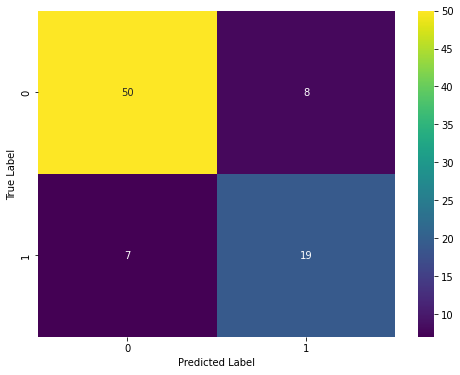

In [306]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test_t, clf_rf_best.predict(X_test_t)),cmap='viridis', annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

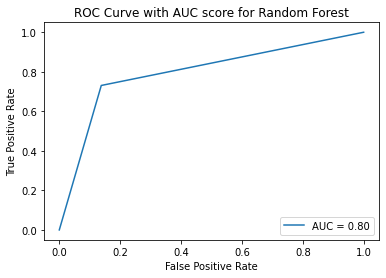

In [307]:
fpr, tpr, thresholds = roc_curve(y_test_t,clf_rf_best.predict(X_test_t))
roc_auc = auc(fpr,tpr)
roc = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc)
roc.plot()
plt.title('ROC Curve with AUC score for Random Forest')
plt.show()

In [308]:
features = X_train_res_t.columns.to_list()
features_val = clf_rf_best.feature_importances_

features_importances = {}

for key,value in zip(features,features_val):
    features_importances[key] = value

sort_features = dict(sorted(features_importances.items(), key=lambda item: item[1], reverse=True))

for key,value in zip(sort_features.keys(), sort_features.values()):
    print(f'{key}:',value)

time: 0.3988492464040559
serum_creatinine: 0.1765954496280574
ejection_fraction: 0.1269758019903507
creatinine_phosphokinase: 0.08248256681926296
age: 0.0624377466698011
platelets: 0.061077611531687406
serum_sodium: 0.06040397292739833
smoking: 0.016426588258554132
high_blood_pressure: 0.007700890470563412
anaemia: 0.007050125300268666


In [312]:
best_features = [feature for feature in sort_features.keys() if sort_features[feature] > 0.08]
best_features

['time', 'serum_creatinine', 'ejection_fraction', 'creatinine_phosphokinase']

In [313]:
from sklearn.svm import SVC
svm = SVC(random_state=5)

svm.fit(X_train_s_res, y_train_s)

SVC(random_state=5)

In [314]:
y_pred = svm.predict(X_test_s)
print(classification_report(y_test,y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8545    0.8103    0.8319        58
           1     0.6207    0.6923    0.6545        26

    accuracy                         0.7738        84
   macro avg     0.7376    0.7513    0.7432        84
weighted avg     0.7822    0.7738    0.7770        84



In [315]:
svm.fit(X_train_st_res, y_train_st)
y_pred = svm.predict(X_test_st)
print(classification_report(y_test_t,y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8889    0.8276    0.8571        58
           1     0.6667    0.7692    0.7143        26

    accuracy                         0.8095        84
   macro avg     0.7778    0.7984    0.7857        84
weighted avg     0.8201    0.8095    0.8129        84



In [349]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.01, n_estimators=180, random_state=5)
xgb.fit(X_train_res_t, y_train_res_t)

[23:27:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, num_parallel_tree=1, random_state=5,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [350]:
y_pred = xgb.predict(X_test_t)
print(classification_report(y_test_t,y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8889    0.8276    0.8571        58
           1     0.6667    0.7692    0.7143        26

    accuracy                         0.8095        84
   macro avg     0.7778    0.7984    0.7857        84
weighted avg     0.8201    0.8095    0.8129        84



In [356]:
import xgboost as xgb
from sklearn.metrics import f1_score
def objective(trial):
    train_x, valid_x, train_y, valid_y = job.load('train_test_for_rf.pkl')#_scaled.pkl')
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)
    scalepos = pd.value_counts(train_y).values

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["n_estimators"] = trial.suggest_int("n_estimators", 50, 500, step=10)
        param["max_depth"] = trial.suggest_int("max_depth", 3, 21, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    f1score = f1_score(valid_y, pred_labels, average='weighted')
    return f1score

In [357]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, timeout=300)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-10-10 23:35:33,197] A new study created in memory with name: no-name-71a46418-47d2-4182-b8e3-0f6f94ebe8d5
[I 2021-10-10 23:35:33,227] Trial 0 finished with value: 0.8129251700680271 and parameters: {'booster': 'dart', 'lambda': 0.08942289805296569, 'alpha': 9.141403042361598e-06, 'subsample': 0.5095798973354799, 'colsample_bytree': 0.6840162501402363, 'n_estimators': 340, 'max_depth': 15, 'min_child_weight': 3, 'eta': 1.3641141214098963e-06, 'gamma': 3.748055444596231e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00026972992265374867, 'skip_drop': 4.707739411023894e-06}. Best is trial 0 with value: 0.8129251700680271.
[I 2021-10-10 23:35:33,254] Trial 1 finished with value: 0.7689594356261024 and parameters: {'booster': 'gbtree', 'lambda': 2.35321727268368e-05, 'alpha': 0.00046855968035605476, 'subsample': 0.7753715657406282, 'colsample_bytree': 0.2847900028921959, 'n_estimators': 120, 'max_depth': 17, 'min_child_weight':

Number of finished trials:  500
Best trial:
  Value: 0.8708807416772018
  Params: 
    booster: dart
    lambda: 0.0004000195457599512
    alpha: 1.9807174037529064e-07
    subsample: 0.8316340776612735
    colsample_bytree: 0.29506106357558937
    n_estimators: 130
    max_depth: 17
    min_child_weight: 8
    eta: 3.49429288430629e-05
    gamma: 1.2248820673269534e-07
    grow_policy: depthwise
    sample_type: weighted
    normalize_type: tree
    rate_drop: 1.5150012023406213e-07
    skip_drop: 0.001447452070058853


In [358]:
optuna.visualization.plot_optimization_history(study).show()

In [359]:
optuna.visualization.plot_parallel_coordinate(study, params=['alpha', 'eta', 'gamma','lambda','max_depth', 'min_child_weight', 'rate_drop']).show()

In [360]:
best_param_xgb = trial.params
best_param_xgb["verbosity"] = 0
best_param_xgb["objective"] = "binary:logistic"
best_param_xgb["tree_method"] = "exact"

In [361]:
xgb_best = XGBClassifier(**best_param_xgb)
xgb_best.fit(X_train_res_t,y_train_res_t)

XGBClassifier(alpha=1.9807174037529064e-07, base_score=0.5, booster='dart',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.29506106357558937, eta=3.49429288430629e-05,
              gamma=1.2248820673269534e-07, gpu_id=-1, grow_policy='depthwise',
              importance_type='gain', interaction_constraints='',
              lambda=0.0004000195457599512, learning_rate=3.49429283e-05,
              max_delta_step=0, max_depth=17, min_child_weight=8, missing=nan,
              monotone_constraints='()', n_estimators=130, n_jobs=4,
              normalize_type='tree', num_parallel_tree=1, random_state=0,
              rate_drop=1.5150012023406213e-07, reg_alpha=1.98071746e-07,
              reg_lambda=0.000400019548, sample_type='weighted',
              scale_pos_weight=1, skip_drop=0.001447452070058853, ...)

In [362]:
y_pred_best = xgb_best.predict(X_test_t)
print(classification_report(y_test_t,y_pred_best, digits=4))

              precision    recall  f1-score   support

           0     0.9091    0.8621    0.8850        58
           1     0.7241    0.8077    0.7636        26

    accuracy                         0.8452        84
   macro avg     0.8166    0.8349    0.8243        84
weighted avg     0.8518    0.8452    0.8474        84



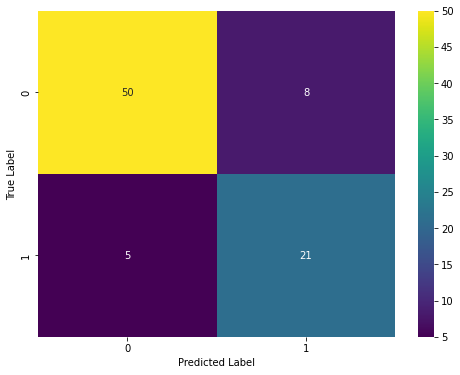

In [363]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test_t, y_pred_best),cmap='viridis', annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

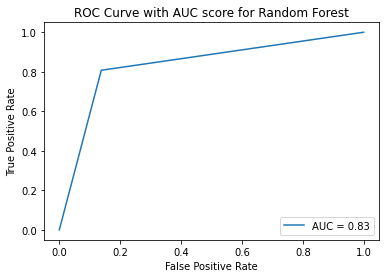

In [364]:
fpr, tpr, thresholds = roc_curve(y_test_t,y_pred_best)
roc_auc = auc(fpr,tpr)
roc = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc)
roc.plot()
plt.title('ROC Curve with AUC score for Random Forest')
plt.show()

In [365]:
features = X_train_res_t.columns.to_list()
features_val = xgb_best.feature_importances_

features_importances = {}

for key,value in zip(features,features_val):
    features_importances[key] = value

sort_features = dict(sorted(features_importances.items(), key=lambda item: item[1], reverse=True))

for key,value in zip(sort_features.keys(), sort_features.values()):
    print(f'{key}:',value)

time: 0.32347155
serum_creatinine: 0.18193965
ejection_fraction: 0.12861978
age: 0.07602688
smoking: 0.07561396
serum_sodium: 0.07382052
creatinine_phosphokinase: 0.05060694
high_blood_pressure: 0.03890446
platelets: 0.031893857
anaemia: 0.019102402
